In [1]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import Adam

from keras.datasets import mnist
import keras.backend as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [37]:
def plot_images(imgs):
    r, c = 5, 5
    # Rescale images 0 - 1
    gen_imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            
            axs[i,j].imshow(gen_imgs[cnt, :,:, 0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

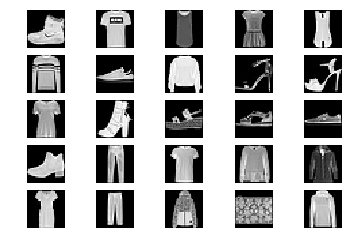

In [9]:
plot_images(x_train)

In [15]:
from keras.layers import *

In [32]:
num_classes = 2
img_shape = (28, 28, 1)
latent_dim = 100

def discriminator():
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    return model

In [33]:
def generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [34]:
g = generator()

optim = Adam(0.0002, 0.5)

# build discriminator
d = discriminator()
d.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])


# build compile model
inputs = Input(shape=(latent_dim, ))
img = g(inputs)
d.trainable = False # Freeze d model
validity = d(img)
combined = Model(inputs, validity)
combined.compile(loss='binary_crossentropy', optimizer=optim)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
__________

(128, 28, 28, 1)
(128, 1)
Accuracy: 0.18359375
Generator loss: 0.604912519454956
Accuracy: 0.671875
Generator loss: 0.7648875117301941
Accuracy: 0.65625
Generator loss: 0.8007422685623169
Accuracy: 0.6796875
Generator loss: 0.8623608350753784
Accuracy: 0.74609375
Generator loss: 0.9227416515350342


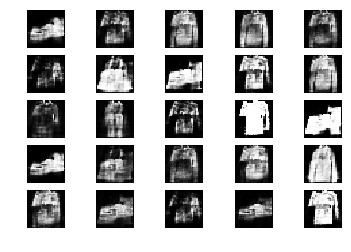

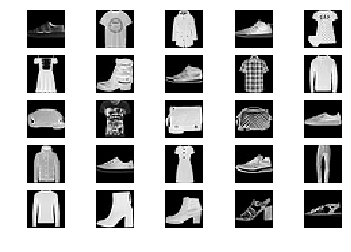

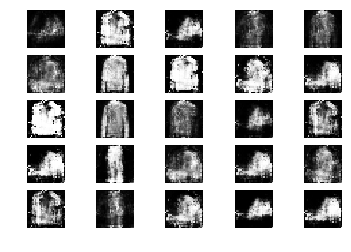

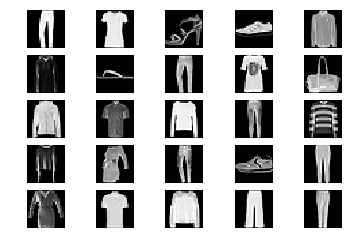

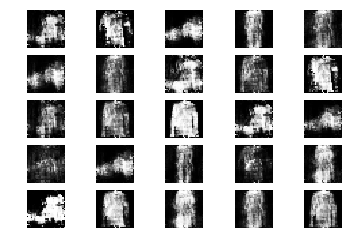

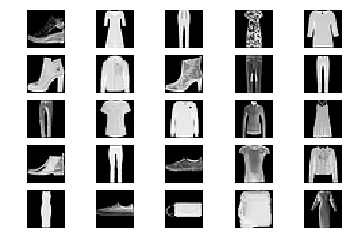

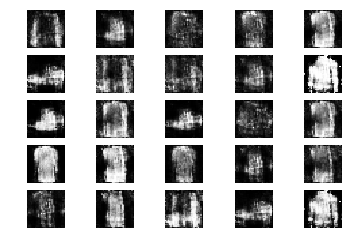

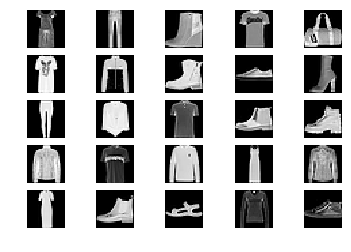

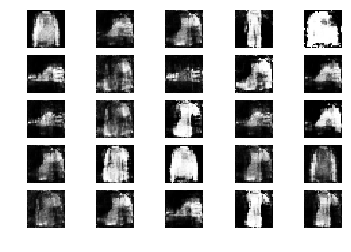

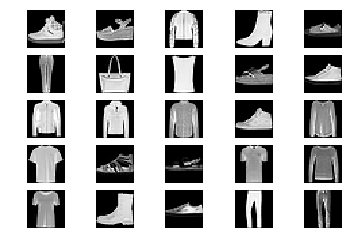

In [38]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

reset_weights(d)
reset_weights(combined)

batch_size = 128

X_train_norm = x_train / 127.5 - 1.
X_train_norm = np.expand_dims(X_train_norm, axis=3)

imgs = X_train_norm[:batch_size]
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

print(imgs.shape)
print(valid.shape)

epochs = 500
k = 1
for epoch in range(epochs):
    
    # train disciminator
    for i in range(k):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = X_train_norm[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        fake_imgs = g.predict(noise)
        d_loss_real = d.train_on_batch(real_imgs, valid)
        d_loss_fake = d.train_on_batch(fake_imgs, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, valid)
    
    if epoch % 100 == 0:
        print("Accuracy: {}".format(d_loss[1]))
#         print(fake_imgs.shape)
        plot_images(fake_imgs)
        plot_images(real_imgs)
        print("Generator loss: {}".format(g_loss))